In [1]:
# Login and database access
import psycopg2
import psycopg2.extras
import getpass

# Plotting
import matplotlib.pyplot as plt
import matplotlib
from IPython.display import display
import ipywidgets

# Math
import numpy as np
import pandas as pd
import copy

The purpose of this notebook is to search through the COSMOS field objects to identify candidates that are likely supernovae. This is done by selecting every candidate that has at least 10 detections over at least 1 month, with a change of at least 1.4 mag, and that doesn't increase in brightness more than once (numbers adjustable below)

In [2]:
dbuser = input("DB User: ")
dbpasswd = getpass.getpass("DB Password: ")

db = psycopg2.connect( f"dbname='decat' user='{dbuser}' password='{dbpasswd}' host='decatdb.lbl.gov'" )
db.autocommit = True # Makes the computer nicer about SQL syntax errors

cursor = db.cursor( cursor_factory = psycopg2.extras.DictCursor )

DB User:  kennedyt
DB Password:  ············


In [3]:
def rm_dupes( arr, ecols=None ):
    """
    Removes duplicate rows from a numpy array. Has functionality to exclude some column(s) from the duplicate-finding process.
    For the purposes of the DECam DDF notebooks, that should be the index of the object ID column, if your array includes it, and left \
    blank if not. For best results, make sure your array includes candidate id, R/B score, and something to tie it to a specific 
    exposure (fnm, eid, etc.)
    
    Takes:
    arr : the original array with some duplicate rows
    ecols : index/indices of excluded columns. NOTE: no matter what this index is, it will be the first column of res
    
    Returns:
    res : the original array with the duplicate rows removed
    """
    if ecols == None:
        dupes = arr
    else:
        dupes = np.delete(arr, ecols, axis=0)
    dupes = np.array( [" ".join(i) for i in dupes.transpose()] )
    unique, ind = np.unique( dupes, return_index=True )
    uarr = np.array( [ i.split(" ") for i in unique ] ).transpose()
    if ecols == None:
        res = uarr
    else:
        res = np.append( [arr[ecols][ind]], uarr, axis=0 )
    print( "%s duplicates removed" % ( len( arr[0] ) - len( res[0] ) ) )
    return res

#### Adjustable parameters

In [4]:
# Minimum timespan between first and last detections in g, r, and i
tspang, tspanr, tspani = 15, 15, 15
# Minimum number of detections in g, r, and i
numdetg, numdetr, numdeti = 10, 10, 10
# Minimum magnitude change in g, r, and i
minmagg, minmagr, minmagi = 0.4, 0.4, 0.4
# The number of standard deviations tolerated to stretch the definition of increasing/decreasing
# (0.3 seems to be the sweet spot, but a little higher works too)
errmult = 0.3
# Maximum average error a candidate's detections can have before they are eliminated from consideration
rmaxerr, gmaxerr, imaxerr = 0.2, 0.2, 0.2


field = "COSMOS"
# field = "ELIAS"

In [5]:
if field == "COSMOS":
    query = ( 'SELECT o.id, o.candidate_id, e.mjd, o.mag, e.filter, o.magerr, e.filename FROM objects o '
             'JOIN subtractions s ON o.subtraction_id=s.id '
             'JOIN exposures e ON e.id=s.exposure_id '
             'WHERE q3c_radial_query(o.ra,o.dec,150,2.2,3) '
             'AND o.rb>0.5 '
             'ORDER BY o.candidate_id '
             'LIMIT 10000000' )
elif field == "ELIAS":
    query = ( 'SELECT o.id, o.candidate_id, e.mjd, o.mag, e.filter, o.magerr, e.filename FROM objects o '
             'JOIN subtractions s ON o.subtraction_id=s.id '
             'JOIN exposures e ON e.id=s.exposure_id '
             'WHERE q3c_radial_query(o.ra,o.dec,8.5,-43.5,2) '
             'AND o.rb>0.5 '
             'ORDER BY o.candidate_id '
             'LIMIT 10000000' )

cursor.execute( query )

SNquery = np.array( cursor.fetchall() ).transpose()

In [6]:
SNquery = rm_dupes(SNquery,0)

2603 duplicates removed


#### Nonstandard exposure time filter

In [7]:
# Reads in lookup table with filenames and exposure times
lutable = np.loadtxt( "archive_image_list.txt", dtype=object ).transpose()
fnmtable, exptable = lutable[0], lutable[7].astype(float)

fnms = SNquery[6]
fnms = [fnms[i][:21] for i in range( len( fnms ) )] # truncate filenames to match lookup table format

# Attach an exposure time to every object we pulled in the query
exptime = np.array( [exptable[ np.where( fnms[i] == fnmtable )[0]][0] for i in range( len( fnms ) )], dtype=float )

In [8]:
# Eliminate objects from non-standard images
gmsk = np.where( ( SNquery[4] == "g" ) & ( exptime > 50 ) )[0]
rmsk = np.where( ( SNquery[4] == "r" ) & ( exptime > 20 ) )[0]
imsk = np.where( ( SNquery[4] == "i" ) & ( exptime > 20 ) )[0]
grmsk = np.append( rmsk, gmsk )
grimsk = np.append( grmsk, imsk )

177104

#### Red filter:

In [9]:
# Mask to make sure we stay in the r band detections
rmsk = np.where( SNquery[4] == "r" )[0]
rmsk = [i for i in grimsk if i in rmsk]

In [10]:
# Separating out various query results and applying the r mask 
candsr, objs, magsr, magerrsr = SNquery[1][rmsk], SNquery[0].astype(float)[rmsk], SNquery[3][rmsk], SNquery[5][rmsk]
# Create an array of the dates rounded to the nearest MJD
odatesr = np.round( SNquery[2].astype(float) )[rmsk]
# create an array of unique night (rounded to nearest MJD)
datesr = np.unique( odatesr )

# Create an array of unique candidates
ucandsr, ucandctsr = np.unique( candsr, return_counts=True )
ucandsr = ucandsr[np.where(ucandctsr > numdetr)[0]]

nummskr = np.isin(candsr, ucandsr, invert=False)
candsr, objs, magsr, magerrsr, odatesr = candsr[nummskr], objs[nummskr], magsr[nummskr], magerrsr[nummskr], odatesr[nummskr]

(21435, 21435, 21435, 21435, 21435)

In [11]:
# Create for each unique candidate an array of the dates it was observed on and store those arrays in a larger array (ucanddatesr)
ucanddatesr = np.array( [odatesr[ np.where( candsr==i )[0] ] for i in ucandsr] )
# Create for each unique candidate an array of measured magnitudes and store those arrays in a larger array (ucandmagsr)
ucandmagsr = np.array( [magsr[ np.where( candsr==i )[0] ] for i in ucandsr] )
# Create for each unique candidate an array of measured magnitude error bars and store those arrays in a larger array (ucandmagerrsr)
ucandmagerrsr = np.array( [magerrsr[ np.where( candsr==i )[0] ] for i in ucandsr] )

In [12]:
# Convert those arrays (previously strings) to floats
ucandmagsr = np.array( [i.astype(float) for i in ucandmagsr] )
ucandmagerrsr = np.array( [i.astype(float) for i in ucandmagerrsr] )
ucanddatesr = np.array( [i.astype(float) for i in ucanddatesr] )

In [13]:
# Calculate how many days passed between the first and last detection 
ucandranger = np.array( [np.max(i) - np.min(i) for i in ucanddatesr] )
# Calculate how many total times the candidates was detected
ucandnumr = np.array( [len(i) for i in ucanddatesr] )

In [14]:
# Make timespan and number of detection cuts
cut1r = np.where( ucandranger > tspanr )[0] # eliminate candidates whose detections dont span at least a month

In [15]:
# Apply those cuts
cutcandsr = ucandsr[cut1r]
cutdatesr = ucanddatesr[cut1r]
cutmagsr = ucandmagsr[cut1r]
cutmagerrsr = ucandmagerrsr[cut1r]

# Create another cut for the minimum amplitude in mag
cutmagranger = np.array( [np.max(i) - np.min(i) for i in cutmagsr] )
cut2r = np.where( cutmagranger > minmagr )[0]

# Create another cut for where the magerror is too high
cutmagerrranger = np.array( [np.mean(i) for i in cutmagerrsr] )
cut3r = np.where( cutmagerrranger < rmaxerr )[0]

cut4r = np.array( [i for i in cut2r if i in cut3r] ).astype(np.int64)

# And apply that cut as well
cutcandsr = ucandsr[cut1r][cut4r]
cutdatesr = ucanddatesr[cut1r][cut4r]
cutmagsr = ucandmagsr[cut1r][cut4r]
cutmagerrsr = ucandmagerrsr[cut1r][cut4r]

/usr/common/software/python/3.7-anaconda-2019.10/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in greater
  if __name__ == '__main__':


In [16]:
# Create new arrays with the same dimensions as the cutdatesr, cutmagsr, and cutmagerrs arrays (those share dimensions)
cutdatesr2 = copy.deepcopy( cutdatesr )
nightr = copy.deepcopy( cutdatesr )
nightrmag = copy.deepcopy( cutdatesr )
nightrmagerr = copy.deepcopy( cutdatesr )

for i in range( len( cutdatesr2 ) ):
    # make an array of every night the candidate in question (candidate "i") was detected
    unightr = np.unique( cutdatesr2[i] )
    for j in range( len( unightr ) ):
        # For each of those nights, make a mask that selects every observation that night
        msk = np.where( cutdatesr2[i] == unightr[j] )[0]
        # Populate the arrays we created earlier in the cell with appropriate values for the night of the observation,
        # the average magnitude measured that night, and the error (propogated from individual errors) in that average measurement
        # NOTE: there will be meaningless numbers at the end of each (nightr/nightrmag/nightrmagerr)[i] array, left over from
        # when we created them by copying another array. It isn't elegant but it is accounted for later
        nightr[i][j] = unightr[j]
        nightrmag[i][j] = np.median( cutmagsr[i][msk] )
        nightrmagerr[i][j] = np.sqrt( np.sum( cutmagerrsr[i][msk]**2 ) )

In [17]:
# Create an array of dataframes. Each dataframe represents one candidate, and each contains "Night", "Mag", and "Magerr" columns, 
# with each row representing one night
dfr = [pd.DataFrame(np.array(
    [nightr[i][:len( np.unique( nightr[i] ) )], 
     nightrmag[i][:len( np.unique( nightr[i] ) )], 
     nightrmagerr[i][:len( np.unique( nightr[i] ) )]]).transpose(),
    columns=["Night",
            "Mag",
            "Magerr"])
 for i in range( len( cutcandsr ) )]

In [18]:
# This cell creates a mask to eliminate variable stars from the search:
varstarmskr = np.ones( len( dfr ), dtype=bool )
for i in range( len( dfr ) ):
    num = 0
    h = 0
    # First, make sure that the dataframes in the dfr array are each in chronological order
    dfr[i] = dfr[i].sort_values( by="Night" )
    for j in range( len( dfr[i]["Mag"] ) - 1 ):
        h += 1
        if ( num >= 0 ) & ( num < 1 ):
            # On the rise, the "current" data point must be lower than the "next" data point (error bars included to give maximum leeway)
            if dfr[i]["Mag"][j] + errmult * dfr[i]["Magerr"][j] > dfr[i]["Mag"][j + 1] - errmult * dfr[i]["Magerr"][j + 1]:
                pass
            else:
                # Once that condition isn't met, 'num' changes, sending us to the descending loop
                num += 1
        if (num >= 1) & (num < 2):
            # On the decline, the "current" data point must be lower than the "next" data point (error bars included to give maximum leeway)
            if dfr[i]["Mag"][j] - errmult * dfr[i]["Magerr"][j] < dfr[i]["Mag"][j + 1] + errmult * dfr[i]["Magerr"][j + 1]:
                pass
            else:
                # If this fails, it means that we went up, down, and up again--not a SN, so
                num += 1
#         if num == 2:
#             if dfr[i]["Mag"][j]+dfr[i]["Magerr"][j] > dfr[i]["Mag"][j+1]-errmult*dfr[i]["Magerr"][j+1]:
#                 pass
#             else:
#                 num+=1
#         if num == 3:
#             if dfr[i]["Mag"][j]-dfr[i]["Magerr"][j] < dfr[i]["Mag"][j+1]+errmult*dfr[i]["Magerr"][j+1]:
#                 pass
#             else:
#                 num+=1
        if num == 2:# and h<10:
            # We make a note of that in the 'varstarmskr' mask
            varstarmskr[i] = False

In [19]:
# Plotting only those that passed through the r-band filter
for f in np.array( range( len( cutdatesr ) ) )[varstarmskr]:
    g = len( np.unique( cutdatesr[f] ) )
#     plt.errorbar(nightr[f][:g],nightrmag[f][:g], yerr=nightrmagerr[f][:g])
#     plt.title(cutcandsr[f] + " (r)")
#     plt.ylabel("Magnitude")
#     plt.xlabel("MJD")
#     plt.gca().invert_yaxis()
#     plt.show()

#### Green filter

In [20]:
### Everything in this section is the same as above besides some altered variable names
gmsk = np.where( SNquery[4] == "g" )[0]
gmsk = [i for i in grimsk if i in gmsk]

In [21]:
candsg, objs, magsg, magerrsg = SNquery[1][gmsk], SNquery[0].astype(float)[gmsk], SNquery[3][gmsk], SNquery[5][gmsk]
odatesg = np.round(SNquery[2].astype(float))[gmsk]
datesg = np.unique(odatesg)

ucandsg, ucandctsg = np.unique(candsg, return_counts=True)
ucandsg = ucandsg[np.where(ucandctsg > numdetg)[0]]

nummskg = np.isin(candsg,ucandsg)
candsg, objs, magsg, magerrsg, odatesg = candsg[nummskg], objs[nummskg], magsg[nummskg], magerrsg[nummskg], odatesg[nummskg]

(27291, 27291, 27291, 27291)

In [22]:
ucanddatesg = np.array([odatesg[np.where(candsg==i)[0]] for i in ucandsg])
ucandmagsg = np.array([magsg[np.where(candsg==i)[0]] for i in ucandsg])
ucandmagerrsg = np.array([magerrsg[np.where(candsg==i)[0]] for i in ucandsg])

CPU times: user 1.5 s, sys: 23.8 ms, total: 1.53 s
Wall time: 1.37 s


In [23]:
ucandmagsg = np.array([i.astype(float) for i in ucandmagsg])
ucandmagerrsg = np.array([i.astype(float) for i in ucandmagerrsg])
ucanddatesg = np.array([i.astype(float) for i in ucanddatesg])

In [24]:
ucandrangeg = np.array([np.max(i) - np.min(i) for i in ucanddatesg])
ucandnumg = np.array([len(i) for i in ucanddatesg])

In [25]:
cut1g = np.where(ucandrangeg > tspang)[0] # eliminate candidates whose detections dont span at least a month

In [26]:
cutcandsg = ucandsg[cut1g]
cutdatesg = ucanddatesg[cut1g]
cutmagsg = ucandmagsg[cut1g]
cutmagerrsg = ucandmagerrsg[cut1g]

cutmagrangeg = np.array([np.max(i) - np.min(i) for i in cutmagsg])
cut2g = np.where(cutmagrangeg > minmagg)[0]
# Create another cut for where the magerror is too high
cutmagerrrangeg = np.array([np.mean(i) for i in cutmagerrsg])
cut3g = np.where(cutmagerrrangeg < gmaxerr)[0]

cut4g = np.array([i for i in cut2g if i in cut3g])


cutcandsg = ucandsg[cut1g][cut4g]
cutdatesg = ucanddatesg[cut1g][cut4g]
cutmagsg = ucandmagsg[cut1g][cut4g]
cutmagerrsg = ucandmagerrsg[cut1g][cut4g]

In [27]:
cutdatesg2 = copy.deepcopy(cutdatesg)
nightg = copy.deepcopy(cutdatesg)
nightgmag = copy.deepcopy(cutdatesg)
nightgmagerr = copy.deepcopy(cutdatesg)

for i in range(len(cutdatesg2)):
    unightg = np.unique(cutdatesg2[i])
    for j in range(len(unightg)):
        msk = np.where(cutdatesg2[i] == unightg[j])[0]
        nightg[i][j] = unightg[j]
        nightgmag[i][j] = np.median(cutmagsg[i][msk])
        nightgmagerr[i][j] = np.sqrt(np.sum(cutmagerrsg[i][msk]**2))

In [28]:
dfg = [pd.DataFrame(np.array(
    [nightg[i][:len(np.unique(nightg[i]))], 
     nightgmag[i][:len(np.unique(nightg[i]))], 
     nightgmagerr[i][:len(np.unique(nightg[i]))]]).transpose(),
    columns=["Night",
            "Mag",
            "Magerr"])
 for i in range(len(cutcandsg))]

In [29]:
varstarmskg = np.ones(len(dfg), dtype=bool)
for i in range(len(dfg)):
    num = 0
    h = 0
    dfg[i] = dfg[i].sort_values(by="Night")
    for j in range(len(dfg[i]["Mag"]) - 1):
        h+=1
        if (num >= 0) & (num < 1):
            if dfg[i]["Mag"][j]+errmult*dfg[i]["Magerr"][j] > dfg[i]["Mag"][j+1]-errmult*dfg[i]["Magerr"][j+1]:
                pass
            else:
                num+=1
        if (num >= 1) & (num < 2):
            if dfg[i]["Mag"][j]-errmult*dfg[i]["Magerr"][j] < dfg[i]["Mag"][j+1]+errmult*dfg[i]["Magerr"][j+1]:
                pass
            else:
                num+=1
#         if num == 2:
#             if dfg[i]["Mag"][j]+dfg[i]["Magerr"][j] > dfg[i]["Mag"][j+1]-errmult*dfg[i]["Magerr"][j+1]:
#                 pass
#             else:
#                 num+=1
#         if num == 3:
#             if dfg[i]["Mag"][j]-dfg[i]["Magerr"][j] < dfg[i]["Mag"][j+1]+errmult*dfg[i]["Magerr"][j+1]:
#                 pass
#             else:
#                 num+=1
        
        if num == 2:# and h<10:
            varstarmskg[i] = False

In [30]:
for f in np.array(range(len(cutdatesg)))[varstarmskg]:
    g = len(np.unique(cutdatesg[f]))
#     plt.errorbar(nightg[f][:g],nightgmag[f][:g], yerr=nightgmagerr[f][:g])
#     plt.title(cutcandsg[f]+" (g)")
#     plt.ylabel("Magnitude")
#     plt.xlabel("MJD")
#     plt.gca().invert_yaxis()
#     plt.show()

#### I filter

In [31]:
### Everything in this section is the same as above besides some altered variable names
imsk = np.where(SNquery[4] == "i")[0]
imsk = [i for i in grimsk if i in imsk]

In [32]:
candsi, objs, magsi, magerrsi = SNquery[1][imsk], SNquery[0].astype(float)[imsk], SNquery[3][imsk], SNquery[5][imsk]
odatesi = np.round(SNquery[2].astype(float))[imsk]
datesi = np.unique(odatesi)

ucandsi, ucandctsi = np.unique( candsi, return_counts=True )
ucandsi = ucandsi[np.where(ucandctsi > numdeti)[0]]

nummski = np.isin(candsi, ucandsi)
candsi, objs, magsi, magerrsi, odatesi = candsi[nummski], objs[nummski], magsi[nummski], magerrsi[nummski], odatesi[nummski]

(7437, 7437, 7437, 7437)

In [33]:
ucanddatesi = np.array([odatesi[np.where(candsi==i)[0]] for i in ucandsi])
ucandmagsi = np.array([magsi[np.where(candsi==i)[0]] for i in ucandsi])
ucandmagerrsi = np.array([magerrsi[np.where(candsi==i)[0]] for i in ucandsi])

CPU times: user 172 ms, sys: 19.8 ms, total: 192 ms
Wall time: 95.7 ms


In [34]:
ucandmagsi = np.array([i.astype(float) for i in ucandmagsi])
ucandmagerrsi = np.array([i.astype(float) for i in ucandmagerrsi])
ucanddatesi = np.array([i.astype(float) for i in ucanddatesi])

In [35]:
ucandrangei = np.array([np.max(i) - np.min(i) for i in ucanddatesi])
ucandnumi = np.array([len(i) for i in ucanddatesi])

In [36]:
cut1i = np.where(ucandrangei > tspani)[0] # eliminate candidates whose detections dont span at least tspani days

In [37]:
cutcandsi = ucandsi[cut1i]
cutdatesi = ucanddatesi[cut1i]
cutmagsi = ucandmagsi[cut1i]
cutmagerrsi = ucandmagerrsi[cut1i]

cutmagrangei = np.array([np.max(i) - np.min(i) for i in cutmagsi])
cut2i = np.where(cutmagrangei > minmagi)[0]
# Create another cut for where the magerror is too high
cutmagerrrangei = np.array([np.mean(i) for i in cutmagerrsi])
cut3i = np.where(cutmagerrrangei < imaxerr)[0]

cut4i = np.array([i for i in cut2i if i in cut3i])


cutcandsi = ucandsi[cut1i][cut4i]
cutdatesi = ucanddatesi[cut1i][cut4i]
cutmagsi = ucandmagsi[cut1i][cut4i]
cutmagerrsi = ucandmagerrsi[cut1i][cut4i]

In [38]:
cutdatesi2 = copy.deepcopy(cutdatesi)
nighti = copy.deepcopy(cutdatesi)
nightimag = copy.deepcopy(cutdatesi)
nightimagerr = copy.deepcopy(cutdatesi)

for i in range(len(cutdatesi2)):
    unighti = np.unique(cutdatesi2[i])
    for j in range(len(unighti)):
        msk = np.where(cutdatesi2[i] == unighti[j])[0]
        nighti[i][j] = unighti[j]
        nightimag[i][j] = np.median(cutmagsi[i][msk])
        nightimagerr[i][j] = np.sqrt(np.sum(cutmagerrsi[i][msk]**2))

In [39]:
dfi = [pd.DataFrame(np.array(
    [nighti[i][:len(np.unique(nighti[i]))], 
     nightimag[i][:len(np.unique(nighti[i]))], 
     nightimagerr[i][:len(np.unique(nighti[i]))]]).transpose(),
    columns=["Night",
            "Mag",
            "Magerr"])
 for i in range(len(cutcandsi))]

In [40]:
varstarmski = np.ones(len(dfi), dtype=bool)
for i in range(len(dfi)):
    num = 0
    h = 0
    dfi[i] = dfi[i].sort_values(by="Night")
    for j in range(len(dfi[i]["Mag"]) - 1):
        h+=1
        if (num >= 0) & (num < 1):
            if dfi[i]["Mag"][j]+errmult*dfi[i]["Magerr"][j] > dfi[i]["Mag"][j+1]-errmult*dfi[i]["Magerr"][j+1]:
                pass
            else:
                num+=1
        if (num >= 1) & (num < 2):
            if dfi[i]["Mag"][j]-errmult*dfi[i]["Magerr"][j] < dfi[i]["Mag"][j+1]+errmult*dfi[i]["Magerr"][j+1]:
                pass
            else:
                num+=1
#         if num == 2:
#             if dfg[i]["Mag"][j]+dfg[i]["Magerr"][j] > dfg[i]["Mag"][j+1]-errmult*dfg[i]["Magerr"][j+1]:
#                 pass
#             else:
#                 num+=1
#         if num == 3:
#             if dfg[i]["Mag"][j]-dfg[i]["Magerr"][j] < dfg[i]["Mag"][j+1]+errmult*dfg[i]["Magerr"][j+1]:
#                 pass
#             else:
#                 num+=1
        
        if num == 2:# and h<10:
            varstarmski[i] = False

In [41]:
for f in np.array(range(len(cutdatesi)))[varstarmski]:
    g = len(np.unique(cutdatesi[f]))
#     plt.errorbar(nightg[f][:g],nightgmag[f][:g], yerr=nightgmagerr[f][:g])
#     plt.title(cutcandsg[f]+" (g)")
#     plt.ylabel("Magnitude")
#     plt.xlabel("MJD")
#     plt.gca().invert_yaxis()
#     plt.show()

#### Putting them together

In [42]:
# Create lists of the candidates that passed each test
SNr = [cutcandsr[f] for f in np.array(range(len(cutdatesr)))[varstarmskr]]
SNg = [cutcandsg[f] for f in np.array(range(len(cutdatesg)))[varstarmskg]]
SNi = [cutcandsi[f] for f in np.array(range(len(cutdatesi)))[varstarmski]]

# Select the ones detected in at least two filters
SNgr = [i for i in SNr if i in SNg]
SNri = [i for i in SNr if i in SNi]
SNgi = [i for i in SNg if i in SNi]
SNgri = np.unique(np.concatenate([SNgr,SNri,SNgi]).flat)

# And those found in all three
SNgold = [i for i in SNgr if i in SNi] # Golden sample
SNgri

array(['DC21bcpi', 'DC21bicq', 'DC21bkrj', 'DC21bpls', 'DC21cove',
       'DC21cxou', 'DC21dhgr', 'DC21dqf', 'DC21dqik', 'DC21dtwb',
       'DC21eqq', 'DC21fber', 'DC21homb', 'DC21hunj', 'DC21ixp',
       'DC21kgy', 'DC21kog', 'DC21ktp', 'DC21kxb', 'DC21url'], dtype='<U8')

In [43]:
# And look at them!
len(SNgri)

20

#### A closer look at these SN

In [44]:
# Taking a look at their coordinates:
for i in SNgri:
    query = ('SELECT c.id, c.ra, c.dec FROM candidates c '
            'WHERE c.id=%s ')
    cursor.execute( query, (i, ) )
    print(cursor.fetchall())

[['DC21bcpi', 151.076568049129, 2.67347244082796]]
[['DC21bicq', 150.378328235109, 2.19651735991065]]
[['DC21bkrj', 150.043978544436, 3.47660190275974]]
[['DC21bpls', 149.300808259448, 2.094409454409]]
[['DC21cove', 150.205260592532, 3.74323011868333]]
[['DC21cxou', 150.17665779001, 4.05871167020173]]
[['DC21dhgr', 148.96669780135, 1.65455109542668]]
[['DC21dqf', 149.936831200786, 2.14923495883583]]
[['DC21dqik', 151.689426712647, 2.00556682067166]]
[['DC21dtwb', 149.302770735739, 1.77949389263242]]
[['DC21eqq', 150.42577440236, 3.40271753256201]]
[['DC21fber', 149.045078531139, 3.17994689983373]]
[['DC21homb', 150.64824267531, 2.31492363575056]]
[['DC21hunj', 150.372933776757, 2.44328182430186]]
[['DC21ixp', 150.726849638736, 2.60341491739695]]
[['DC21kgy', 149.877238942451, 2.40367842891255]]
[['DC21kog', 151.123031420262, 1.10577376817372]]
[['DC21ktp', 149.385740426683, 2.8139035077278]]
[['DC21kxb', 150.732358932859, 2.95252258401769]]
[['DC21url', 149.786414460809, 1.618678051063

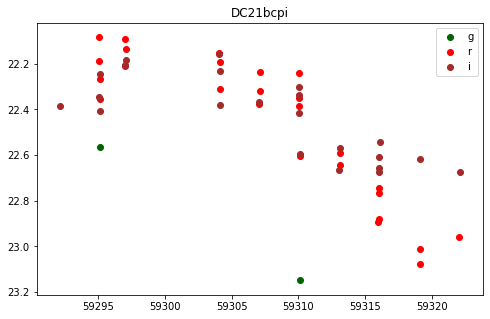

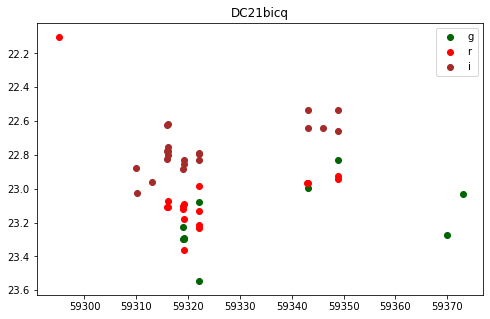

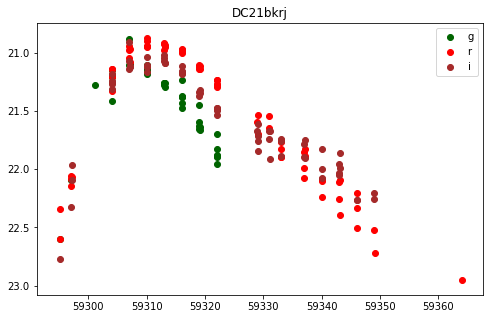

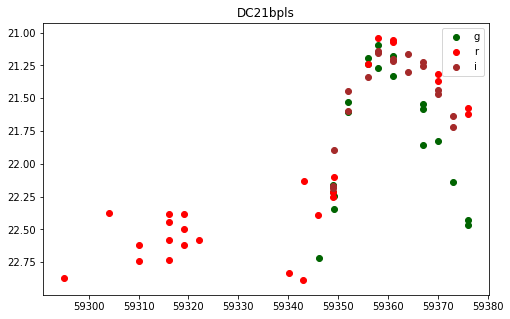

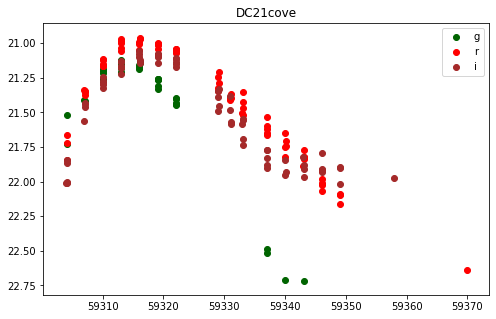

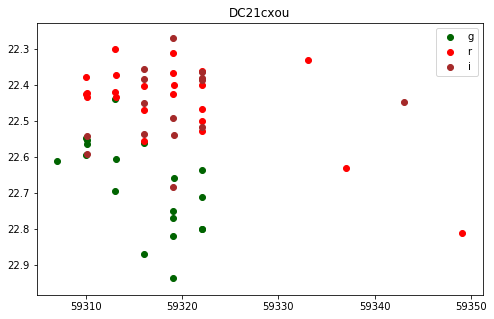

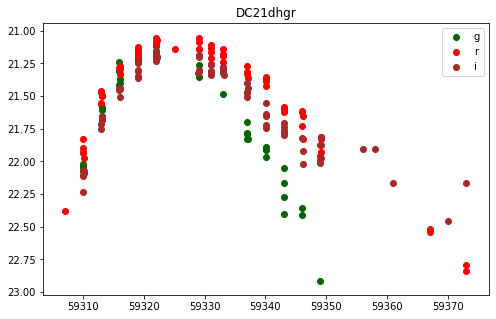

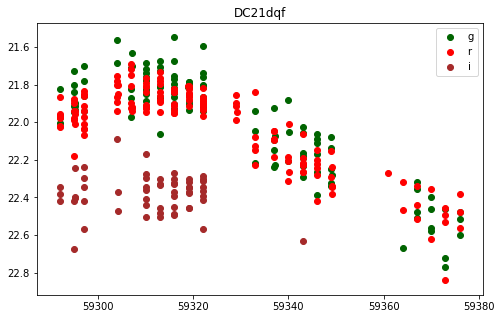

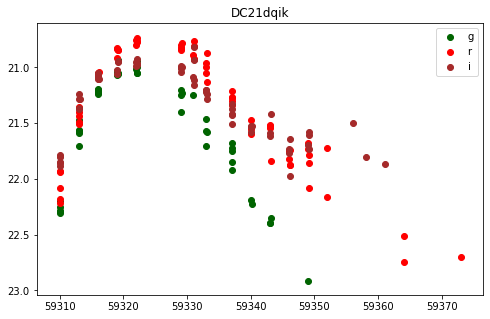

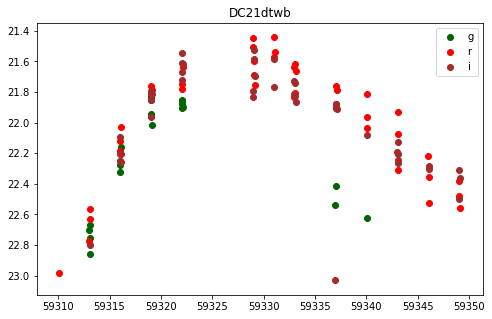

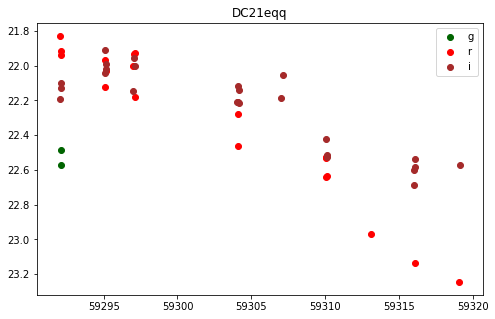

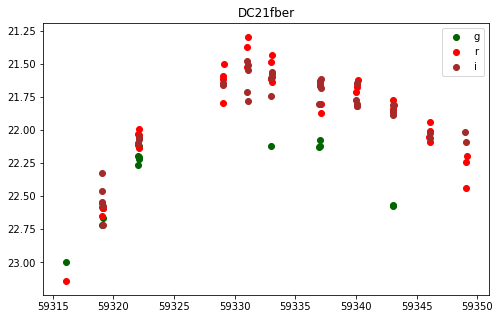

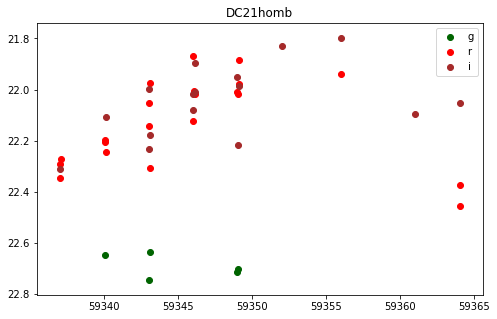

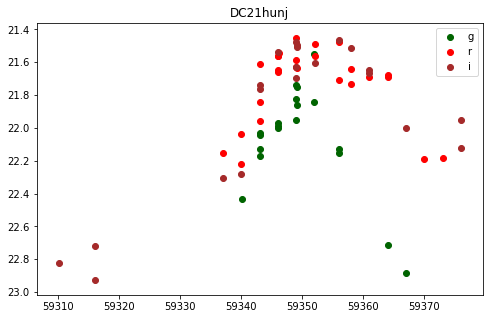

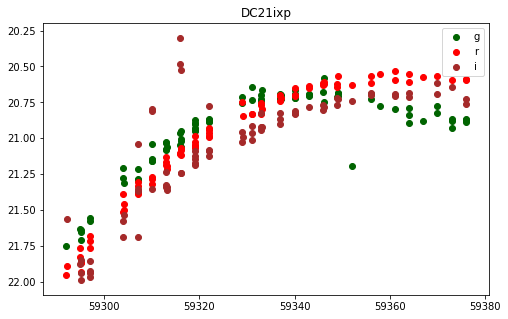

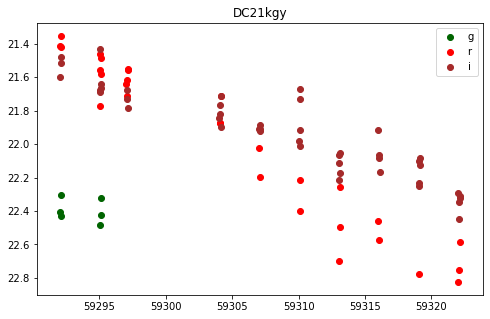

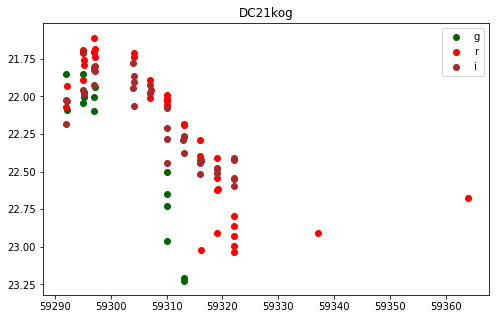

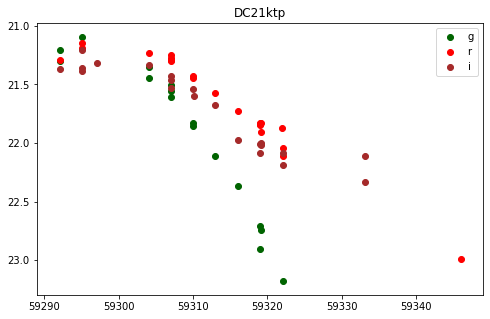

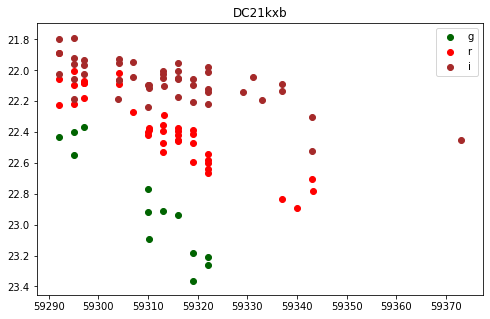

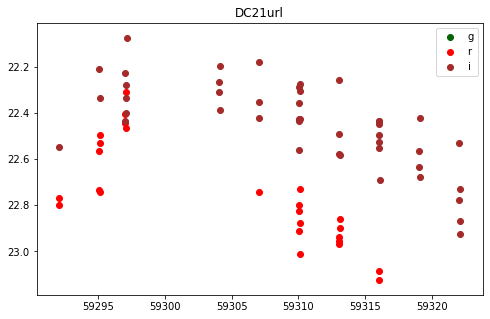

In [45]:
if field == "COSMOS": c = ["darkgreen","red","brown"]
elif field == "ELIAS": c = ["limegreen","darkorange","peru"]

# Plotting lightcurves for each potential SN
for i in SNgri:
    query = ('SELECT c.id, e.mjd, o.mag, e.filter FROM objects o '
             'JOIN candidates c ON c.id=o.candidate_id '
             'JOIN subtractions s ON s.id=o.subtraction_id '
             'JOIN exposures e ON e.id=s.exposure_id '
            'WHERE c.id=%s ')
    cursor.execute( query, (i, ) )
    array = np.array(cursor.fetchall()).transpose()
    rmsk = np.where(array[3]=='r')[0]
    gmsk = np.where(array[3]=='g')[0]
    imsk = np.where(array[3]=='i')[0]
    
    plt.figure(figsize=(8,5))
    plt.scatter((array[1][gmsk]).astype(float), (array[2][gmsk]).astype(float), color=c[0], label='g')
    plt.scatter((array[1][rmsk]).astype(float), (array[2][rmsk]).astype(float), color=c[1], label='r')
    plt.scatter((array[1][imsk]).astype(float), (array[2][imsk]).astype(float), color=c[2], label='i')

    plt.title(array[0][0])
    plt.gca().invert_yaxis()
    plt.legend()
    plt.show()

In [46]:
### This cell pulls out the reference, science, and subtraction images for eack of the SNe the filter detected, for every good detection

for i in SNgri:
    query = ( 'SELECT cand.id, e.mjd,e.filename,e.filter,c.sci_jpeg,c.ref_jpeg,c.diff_jpeg FROM cutouts c '
              'INNER JOIN objects o ON c.object_id=o.id '
              'INNER JOIN candidates cand ON o.candidate_id=cand.id '
              'INNER JOIN subtractions s ON o.subtraction_id=s.id '
              'INNER JOIN exposures e ON s.exposure_id=e.id '
              'WHERE cand.id=%s '
              'AND o.rb>0.6 '
              'ORDER BY e.mjd '
              'LIMIT 3')
    cursor.execute( query, ( i, ) )
    for row in cursor:
        label = ipywidgets.HTML( f'<b>Candidate</b>{row["id"]}<br><b>{row["filename"]}</b><br><b>Filter:</b> {row["filter"]}' )
        newimg = ipywidgets.Image( value=bytes(row["sci_jpeg"]), width=102, height=102, format='jpeg' )
        refimg = ipywidgets.Image( value=bytes(row["ref_jpeg"]), width=102, height=102, format='jpeg' )
        subimg = ipywidgets.Image( value=bytes(row["diff_jpeg"]), width=102, height=102, format='jpeg' )
        box = ipywidgets.HBox( [ newimg, refimg, subimg, label ] )
        display( box )
    print("")
    print("")    
    print("")    
    print("")    